# MLTS Exercise 04 - Gaussian Process Regression

The goal of this exercise is to develop Gaussian process (GP) prior and posterior using different kernel methods and to draw random functions from them. To understand the GPs, you can refer to the book *“Gaussian Processes for Machine Learning”, [Rasmussen & Williams, 2006]*

We have a training set $D$ of $n$ observations, $D=\{(x_i, y_i), i = 1, …, n\}$ where $x$ denotes an input vector of dimension $d$ and $y$ denotes a scalar output or target (dependent variable); the column vector inputs for all $n$ cases are aggregated in the $d × n$ design matrix $X$ and the targets are collected in the vector $y$, so we can write $D = (X, y)$. Regression is a problem of finding a function $f(x)$ that maps the input $X$ to the target $y$ and in this exercise we are interested in using Gaussian processes to find such a function.

A **Gaussian process** is a collection of random variables, any finite number of which have a joint Gaussian distribution. A Gaussian process is completely specified by its mean function and covariance function. We define mean function $m(x)$ and the covariance function $k(x, x')$ of a real process $f(x)$ as 

$m(x) = \mathbb{E}[f(x)],$  
$k(x, x') = \mathbb{E}[(f(x) - m(x))(f(x') - m(x'))]$  

and will write the Gaussian process as

$f(x) \sim GP(m(x), k(x, x'))$  

The specification of the **covariance function** implies a *distribution over functions*. To see this, we can draw samples from the distribution of functions evaluated at any number of points; in detail, we choose a number of input points $X_*$ and write out the corresponding covariance matrix element-wise. Then we generate a random Gaussian vector with this covariance matrix

$f_* \sim N(0, K(X_*, X_*))$

and plot the generated values as a function of the inputs. The following figure shows such samples from prior (before having any observation) and posterior (after having some observations) distribution.

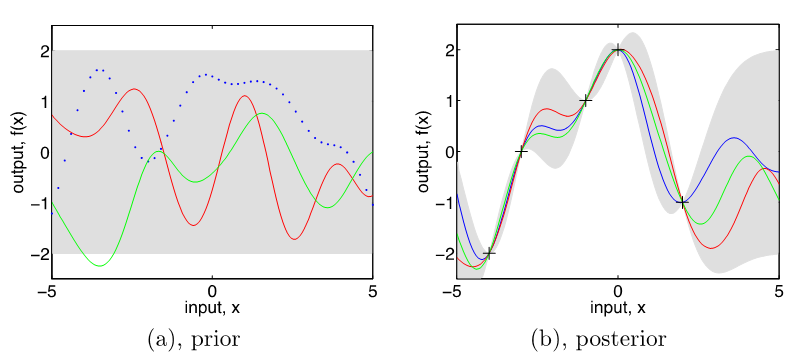  
Figure shows 3 random functions sampled from prior and posterior. The shaded area corresponds to 2 times standard deviation plus and minus mean.

We consider a **Gaussian process prior** with zero mean and covariance function $k(X_*, X_*)$

$f_x \sim N(0, K(X_*, X_*))$

After observing data points and constructing likelihood, the **posterior distribution** becomes a multivariate **Gaussian distribution** with the following mean and covariance 

$\textbf{f}_*|X_*, X, f \sim N(K(X_*, X) K(X, X)^{-1} \textbf{f}, K(X_*, X_*) - K(X_*, X) K(X, X)^{-1} K(X, X_*))$

In [7]:
%matplotlib widget
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets as widgets

In [ ]:
# Define random seed for reproduceable results
random_seed = 42

In [8]:
def plot_gp(x: np.array, y: np.array, interval: np.array,
            mean_gp: np.array, cov_gp: np.array, sampled_func: np.array) -> None:
    """Plot Gausian Process

    Args:
        x (np.array): Observations X
        y (np.array): Observations Y
        interval (np.array): Relevant interval
        mean_gp (np.array): GP mean
        cov_gp (np.array): GP covariance matrix
        sampled_func (np.array): Sampled function
    """
    plt.close('all')
    # plotting
    fig = plt.figure(figsize=(8, 5))
    if x is not None:
        plt.plot(x, y, '+', label='Data points')
    plt.plot(interval, sampled_func, 'b-', linewidth=2, markersize=10, label='Sampled function')
    # fm = np.zeros((len(interval), 1))
    plt.plot(interval, mean_gp, 'k-', linewidth=2, label='Mean')
    fstd = np.sqrt(np.diag(cov_gp))
    # 2*std corresponds to 95% confidence interval
    plt.fill_between(interval, mean_gp - fstd * 2, mean_gp + fstd * 2, alpha=0.2, color='k', label='2 * STD')

    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.subplots_adjust(right=0.75)
    plt.show()

### Task: Define kernels for Gaussian Process Regression 

##### Squared Exponential:

$k_1(x, x') = \theta_1 exp(-(x - x')^2 / \theta_2^2)$

##### Ornstein-Uhlenbeck:

$k_2(x, x') = \theta_1 exp(- ||x - x'|| / \theta_2^2)$

##### Periodic:

$k_3(x, x') = \theta_1 exp(-2 sin^2(\pi |x - x'|) / \theta_2^2)$

##### Linear:

$k_4(x, x') = \theta_1 x \cdot x'$

Here $\theta_1\in \mathcal{R}$ and $\theta_2\in \mathcal{R}$ are hyperparameters

1) Define the kernels

2) Calculate the covariance matrix for the observations


In [3]:
def get_K(knr: int, t: np.array, x: np.array) -> np.array:
    """Select a kernel and generate the covariance matrix.

    Args:
        knr (int): kernal number
        t (np.array): Observations 1
        x (np.array): Observations 2

    Returns:
        np.array: covariance matrix
    """
    # hyperparameters
    sig_1 = 1
    div_sig_2_quad = 10  # parameter representing 1 / sigmar_2 ^ 2

    # define Kernel
    if knr == 1: # Squared exponential for vectors
        k = lambda x, y: sig_1 * np.exp(- (x - y).T * (x - y) * div_sig_2_quad)
    elif knr == 2: # Ornstein-Uhlenbeck
       k = lambda x, y: sig_1 * np.exp(- np.linalg.norm(x - y) * div_sig_2_quad)
    elif knr == 3: # periodic GP
        div_sig_2_quad = 1
        k = lambda x, y: sig_1 * np.exp(- 2 * np.power(np.sin(np.pi * np.abs(x - y)), 2) * div_sig_2_quad)
    elif knr == 4: # Linear
        k = lambda x, y: sig_1 * x.T * y

    n = len(t)
    m = len(x)
    K = np.zeros((n, m))

    # calculate covariance matrix
    for i in range(n):
        for j in range(m):
            K[i, j] = k(t[i], x[j])

    return K

### Task: Sampling from Gaussian prior/posterior

The task is to generate random functions from prior and posterior. In order to do that, we need to compute the mean and covariance matrix for prior and posterior. We can use different covariance functions as given above to compute the covariance matrices. The free parameters of the kernels can be set to different values to see the effect of kernel parameters in the form of sample functions.

Sampling from Gaussian prior and posterior
1. Compute covariance (kernel) matrix $k(x, x')$
2. Apply Cholesky decomposition on covariance matrix 
$K = LL^T$ where $L$ is the lower triangular matrix for $K$. 

3. Generate a vector of random normally distributed samples $z = {z_1, z_2, …, z_n}$. 
4. The random functions can be obtained $f = m(x) + Lz$

The Cholesky matrix transforms uncorrelated variables $z$ into variables whose variances and covariances are given by $K$. 
Hint: If you face some numerical problems performing Cholesky decomposition, just add a very small noise to the data. It makes decomposition stable.

$K = K + \sigma_{noise} I$


In [17]:
def sampleGP(n: int, mean_gp: np.array, cov_gp: np.array) -> np.array:
    """Sampling from Gaussian prior/posterior.

    Args:
        n (int): length of vector t
        mean_gp (np.array): mean of gaussian distribution
        cov_gp (np.array): covariance matrix

    Returns:
        np.array: Generated function
    """
    # prevent ill posed matrix
    sigma = 1e-5
    cov_gp = cov_gp + sigma * np.eye(len(cov_gp))

    # implement the sampling
    np.random.seed(random_seed)
    z = np.random.randn(n)
    L = np.linalg.cholesky(cov_gp)
    f = mean_gp + L @ z

    return f

### Sampling f from Gaussian Posterior without Observations

In [9]:
@widgets.interact(
    kernel_nr=widgets.IntSlider(min=1, max=4, step=1, value=1, description='kernel function number: ')
)
def plot(kernel_nr=1):
    # interval t
    t = np.linspace(-1, 1, 200)

    # Sample from Prior (covariance matrix)
    K = get_K(kernel_nr, t, t)

    # sample function f
    mean = np.zeros(len(t))
    f = sampleGP(len(t), mean, K)

    plot_gp(None, None, t, mean, K, f)

interactive(children=(IntSlider(value=1, description='kernel function number: ', max=4, min=1), Output()), _do…

### Task: Sampling f from Gaussian Posterior with Observations X

In [14]:
@widgets.interact(
    kernel_nr=widgets.IntSlider(min=1, max=4, step=1, value=1, description='kernel function number: '),
    number_ran=widgets.IntSlider(min=1, max=10, step=1, value=3, description='Number of observations: '),
    true_func=['sin', 'cos', 'exp', 'lin']
)
def plot(kernel_nr=1, number_ran=3, true_func='sin'):
    # Sample from Posterior
    # Observed data points, just some examples
    Xtrain = np.random.uniform(-1, 1, size=number_ran)
    if true_func == 'sin':
        Ytrain = np.sin(Xtrain)
    elif true_func == 'cos':
        Ytrain = np.cos(Xtrain)
    elif true_func == 'exp':
        Ytrain = np.exp(Xtrain)
    elif true_func == 'lin':
        Ytrain = Xtrain

    # interval t
    t = np.linspace(-1, 1, 200)

    # Posterior mean and covariance
    # Covariance for observations
    K = get_K(kernel_nr, Xtrain, Xtrain)

    # only for avoiding numerical problems
    sigma = 1e-5
    K += sigma * np.eye(len(K))

    # Inverse of observation coveriance
    K_inv = np.linalg.inv(K)

    # Covariance between observations and chosen interval
    Ks = get_K(kernel_nr, Xtrain, t)

    # Covariance in chosen interval
    Kss = get_K(kernel_nr, t, t)

    # Posterior Mean
    postMu = np.transpose(Ks).dot(K_inv).dot(Ytrain)

    # Posterior Covariance
    postCov = Kss - np.dot(np.dot(np.transpose(Ks), K_inv), Ks)

    # Sample function f
    fs = sampleGP(len(postMu), postMu, postCov)

    plot_gp(Xtrain, Ytrain, t, postMu, postCov, fs)

interactive(children=(IntSlider(value=1, description='kernel function number: ', max=4, min=1), IntSlider(valu…